In [2]:
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=MOHSIN\SQLEXPRESS;'
                      'Database=AData;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

In [5]:
SQL_Query = pd.read_sql_query('''select * FROM AData.dbo.AppleStore''', conn)
df = pd.DataFrame(SQL_Query)
df.head(3)

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


In [6]:
df.isnull().sum()

id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices_num     0
ipadSc_urls_num     0
lang_num            0
vpp_lic             0
dtype: int64

In [7]:
#Checking number of unique apps in Apple Store 
UniqueApps = pd.read_sql_query('''select Count(Distinct id) FROM AData.dbo.AppleStore''', conn)
print('Total unique apps found are: ',UniqueApps)

Total unique apps found are:         
0  7197


In [8]:
topGenre = pd.read_sql_query('''Select top(5) prime_genre as Genre, Count(*) as NumberApps
                                from AppleStore
                                group by prime_genre
                                order by NumberApps desc''',
                            conn)
topGenre = pd.DataFrame(topGenre)
topGenre

,Genre,NumberApps
0,Games,3862
1,Entertainment,535
2,Education,453
3,Photo & Video,349
4,Utilities,248


In [9]:
appRatings = pd.read_sql_query('''  Select min(user_rating) as MinRating, 
                                    max(user_rating) as MaxRating,
                                    avg(user_rating) as AvgRating
                                    from AppleStore''',
                            conn)
appRatings

,MinRating,MaxRating,AvgRating
0,0.0,5.0,3.526956


In [10]:
popApps = pd.read_sql_query(''' Select Case
                                when price > 0 then 'Paid'
	                            else 'Free'
                                End as AppType, avg(user_rating) as AvgRating
                                from AppleStore
                                group by
                                    Case
	                                    when price > 0 then 'Paid'
                                        else 'Free'
                                    End''',
                            conn)
popApps

,AppType,AvgRating
0,Paid,3.720949
1,Free,3.376726


In [11]:
langSupport = pd.read_sql_query(''' Select Case
                                        when lang_num < 10 then 'Less then 10 languages'
                                        when lang_num Between 10 and 30 then 'Between 10 & 30 languages'
                                        else 'More then 30 languages'
                                    end as Language_Support, avg(user_rating) as AvgRating
                                    from AppleStore
                                    group by
                                    Case
                                        when lang_num < 10 then 'Less then 10 languages'
                                        when lang_num Between 10 and 30 then 'Between 10 & 30 languages'
                                        else 'More then 30 languages'
                                    end
                                    order by AvgRating desc''',
                                conn)

langSupport

,Language_Support,AvgRating
0,Between 10 & 30 languages,4.130512
1,More then 30 languages,3.777778
2,Less then 10 languages,3.368327


In [12]:
lowerRatings = pd.read_sql_query('''Select Top(5) prime_genre as Genre, avg(user_rating) as AvgRating
                                    from AppleStore
                                    group by prime_genre
                                    order by AvgRating ''',
                                conn)
lowerRatings

,Genre,AvgRating
0,Catalogs,2.100000
1,Finance,2.432692
2,Book,2.477679
3,Navigation,2.684783
4,Lifestyle,2.805556


In [13]:
corrDR=pd.read_sql_query('''Select Case
                                when len(d.app_desc) < 500 then 'Short'
                                when len(d.app_desc) Between 500 and 1000 then 'Medium'
                                else 'Long'
                            End as Description_Length, avg(user_rating) as AvgRating
                        from AppleStore as A 
                        join appleStore_description as D
                        on A.id = D.id
                        group by
                            Case
                                when len(d.app_desc) < 500 then 'Short'
                                when len(d.app_desc) Between 500 and 1000 then 'Medium'
                                else 'Long'
                            End
                        order by AvgRating desc''',
                    conn)

corrDR = pd.DataFrame(corrDR)
corrDR


,Description_Length,AvgRating
0,Long,3.640296
1,Medium,3.321507
2,Short,3.095989


In [15]:
topAppGenre = pd.read_sql_query(''' Select top(5) prime_genre as Genre, track_name as Track, user_rating as Rating
                                    from 
                                    (	Select	prime_genre, 
                                                track_name, 
                                                user_rating,
                                                RANK() over (Partition by prime_genre order by user_rating desc, rating_count_tot desc) as rank
                                        from AppleStore
                                    ) as a
                                    where a.rank = 1''',
                                conn)

topAppGenre

,Genre,Track,Rating
0,Book,Color Therapy Adult Coloring Book for Adults,5.0
1,Business,TurboScanâ„¢ Pro - document & receipt scanner:...,5.0
2,Catalogs,CPlus for Craigslist app - mobile classifieds,5.0
3,Education,Elevate - Brain Training and Games,5.0
4,Entertainment,Bruh-Button,5.0


In [16]:
bestRatings = pd.read_sql_query(''' Select top(5) track_name as Track, Sum(rating_count_tot) as Ratings
                                    from AppleStore
                                    group by track_name
                                    order by ratings desc''',
                                conn)

bestRatings=pd.DataFrame(bestRatings)
bestRatings

,Track,Ratings
0,Facebook,2974676
1,Instagram,2161558
2,Clash of Clans,2130805
3,Temple Run,1724546
4,Pandora - Music & Radio,1126879


<BarContainer object of 5 artists>

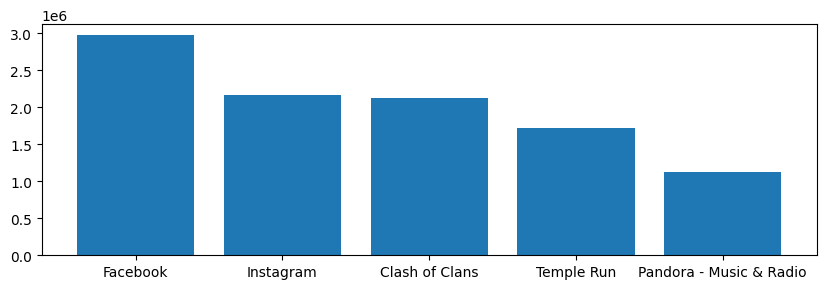

In [17]:
plt.figure(figsize=(10,3))
plt.bar('Track', 'Ratings', data=bestRatings)

In [18]:
bestPrice = pd.read_sql_query('''Select top(5) track_name, Sum(price) as Price
                                    from AppleStore
                                    group by track_name
                                    order by Price desc''',
                              conn)

bestPrice = pd.DataFrame(bestPrice)
bestPrice

,track_name,Price
0,LAMP Words For Life,299.989990
1,Proloquo2Go - Symbol-based AAC,249.990005
2,KNFB Reader,99.989998
3,NAVIGON Europe,74.989998
4,Articulation Station Pro,59.990002


<BarContainer object of 5 artists>

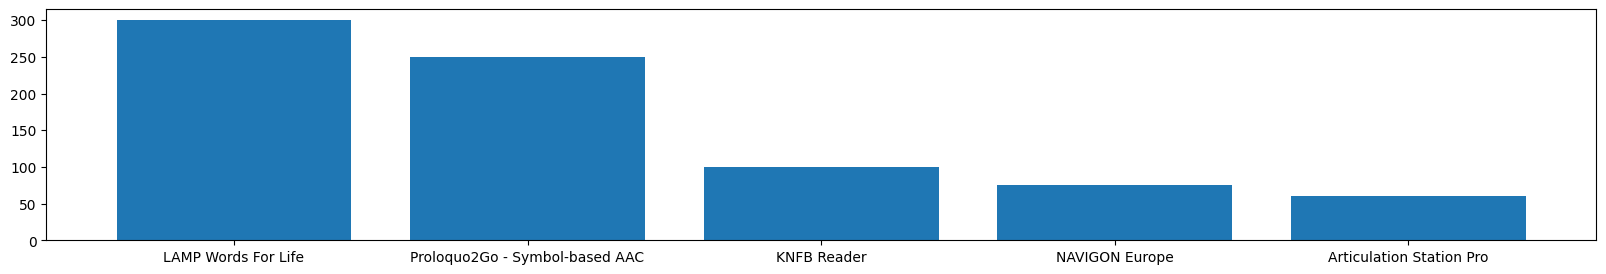

In [19]:
plt.figure(figsize=(20,3))
plt.bar('track_name', 'Price', data=bestPrice)

In [20]:
topRevenue = pd.read_sql_query(''' Select top(5) track_name as Track, Sum(rating_count_tot * price) as Revenue
                                    from AppleStore
                                    group by track_name
                                    order by revenue desc''',
                               conn)

topRevenue=pd.DataFrame(topRevenue)
topRevenue

,Track,Revenue
0,Minecraft: Pocket Edition,3.648864e+06
1,Fruit Ninja Classic,1.390047e+06
2,Draw Something,1.079312e+06
3,SCRABBLE Premium,8.451502e+05
4,Call of Duty: Black Ops Zombies,8.150409e+05


<BarContainer object of 5 artists>

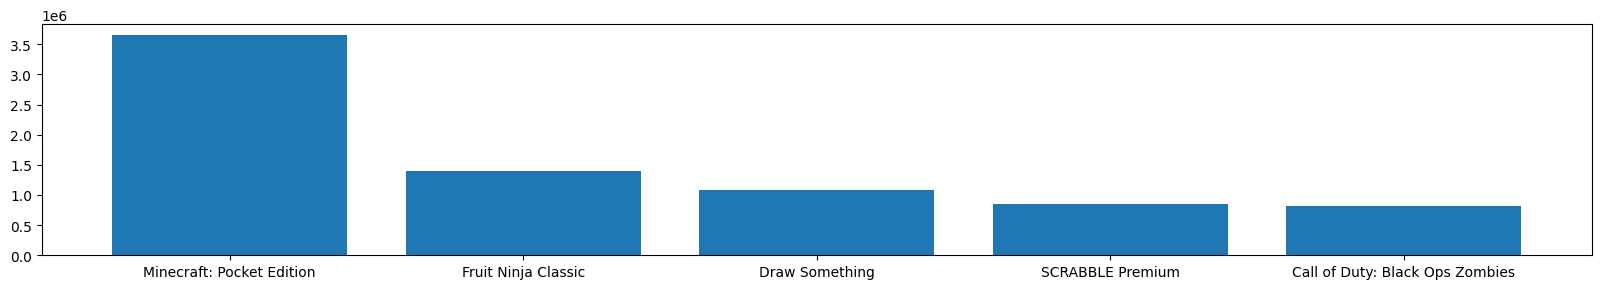

In [21]:
plt.figure(figsize=(20,3))
plt.bar('Track', 'Revenue', data=topRevenue)

In [22]:
userFav = pd.read_sql_query(''' Select top(5) track_name as Track, Sum(rating_count_tot * user_rating) as User_Fav
                                    from AppleStore
                                    group by track_name
                                    order by User_Fav desc''',
                            conn)

userFav = pd.DataFrame(userFav)
userFav

,Track,User_Fav
0,Facebook,10411366.0
1,Instagram,9727011.0
2,Clash of Clans,9588622.0
3,Temple Run,7760457.0
4,Pinterest,4777308.0


<BarContainer object of 5 artists>

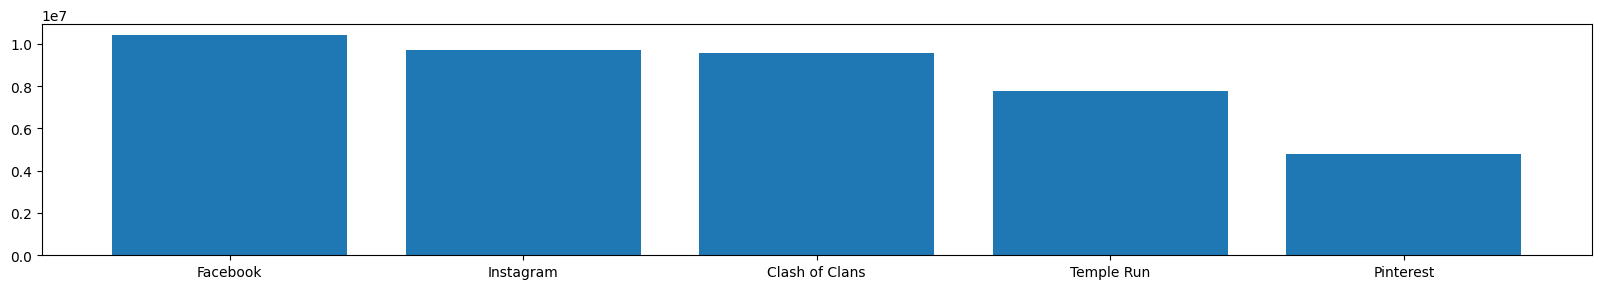

In [23]:
plt.figure(figsize=(20,3))
plt.bar('Track', 'User_Fav', data=userFav)

<BarContainer object of 4 artists>

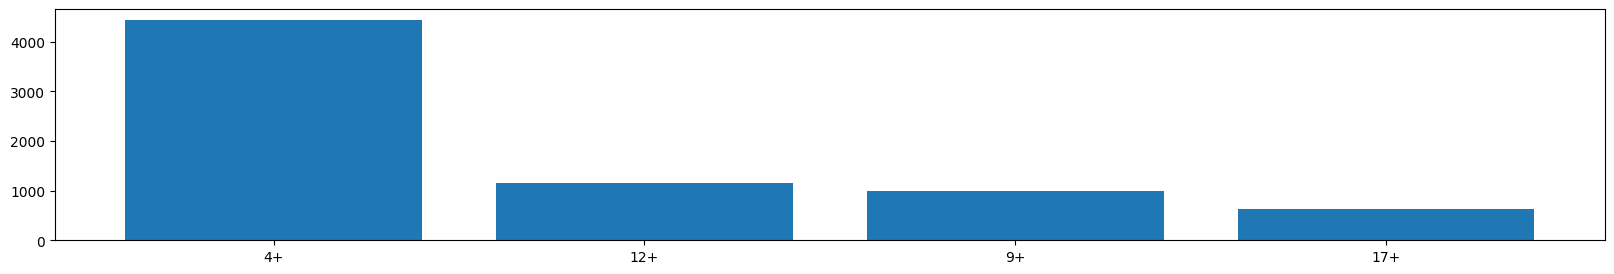

In [24]:
popContent = pd.read_sql_query(''' Select cont_rating as Content, Count(*) as AppsCount
                                    from AppleStore
                                    group by cont_rating
                                    order by AppsCount desc''',
                               conn)

popContent = pd.DataFrame(popContent)
plt.figure(figsize=(20,3))
plt.bar('Content', 'AppsCount', data=popContent)

In [25]:
favVersion = pd.read_sql_query('''Select top(5) track_name as Track, Sum(rating_count_ver * user_rating_ver) as Fav_Ver
                                    from AppleStore
                                    group by track_name
                                    order by Fav_Ver desc''',
                            conn)
favVersion=pd.DataFrame(favVersion)
favVersion

,Track,Fav_Ver
0,Infinity Blade,885250.0
1,Geometry Dash Meltdown,528615.0
2,My Verizon,482602.5
3,Real Basketball,424417.5
4,Zillow Real Estate - Homes for Sale & for Rent,398151.0


<BarContainer object of 5 artists>

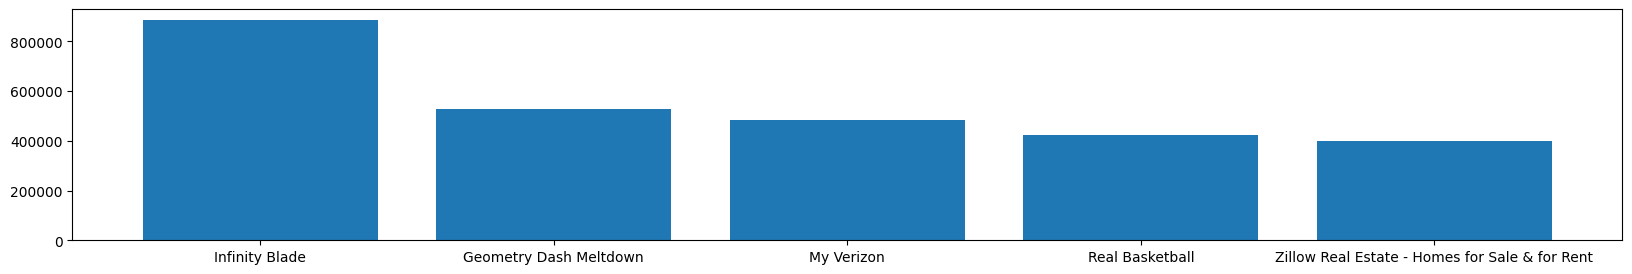

In [26]:
plt.figure(figsize=(20,3))
plt.bar('Track', 'Fav_Ver', data=favVersion)